In [2]:
import os
os.chdir('/Users/younghun/Desktop/gitrepo/data/mercari-price-suggestion-challenge/')

In [3]:
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd

mercari_df = pd.read_csv('train.tsv', sep='\t')
print(mercari_df.shape)
mercari_df.head(3)

(1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


In [4]:
import gc
gc.collect()

40

<AxesSubplot:xlabel='price'>

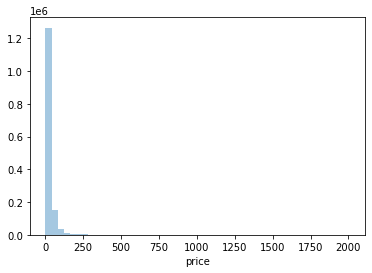

In [6]:
# 타겟변수의 분포도 확인
import matplotlib.pyplot as plt
import seaborn as sns

y_train_df = mercari_df['price']
plt.figure(figsize=(6,4))
sns.distplot(y_train_df, kde=False)

<AxesSubplot:xlabel='price'>

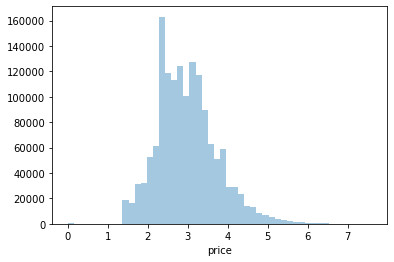

In [7]:
# 타겟변수에 log 1+ 취해줘서 정규분포화 시켜주기
import numpy as np
y_train_df = np.log1p(y_train_df)
sns.distplot(y_train_df, kde=False)

In [8]:
# 로그취한 값을 원본데이터의 타겟변수로 저장하자
mercari_df['price'] = np.log1p(mercari_df['price'])
mercari_df['price'].head()

0    2.397895
1    3.970292
2    2.397895
3    3.583519
4    3.806662
Name: price, dtype: float64

In [9]:
# 각 feature 유형 살펴보기
mercari_df['shipping'].value_counts()

0    819435
1    663100
Name: shipping, dtype: int64

In [10]:
mercari_df['item_condition_id'].value_counts()

1    640549
3    432161
2    375479
4     31962
5      2384
Name: item_condition_id, dtype: int64

In [11]:
mercari_df.isnull().sum()

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64

In [16]:
# 상품 설명에 결측치이지만 문자열이 들어간 데이터들 개수 출력
bool_cond = mercari_df['item_description'] == 'No description yet'
mercari_df[bool_cond]['item_description'].count()

82489

In [27]:
# 카테고리 네임을 분할하기
def split_cat(category_name):
    try:
        return category_name.split('/')
    except:
        # 카테고리이름이 /로이루어져있지 않으면 아래와 같이 출력
        return ['Other_Null','Other_Null','Other_Null']
# *표란 뒤에 있는 것들을 튜플로 담아줘!! 라는 뜻! 
# zip은 인자에 있는 것들을 하나 씩 풀어주기
mercari_df['cat_dae'], mercari_df['cat_jung'], mercari_df['cat_so'] = \
zip(*mercari_df['category_name'].apply(lambda x: split_cat(x)))

print('대분류 유형\n', mercari_df['cat_dae'].value_counts())
print('중분류 유형\n', mercari_df['cat_jung'].value_counts())
print('소분류 유형\n', mercari_df['cat_so'].value_counts())

대분류 유형
 Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Other_Null                  6327
Name: cat_dae, dtype: int64
중분류 유형
 Athletic Apparel        134383
Makeup                  124624
Tops & Blouses          106960
Shoes                   100452
Jewelry                  61763
                         ...  
Candles                     64
Ceramics and Pottery        57
Dolls and Miniatures        49
Books and Zines             46
Quilts                      31
Name: cat_jung, Length: 114, dtype: int64
소분류 유형
 Pants, Tights, Leggings    60177
Other                      50224
Face                       50171
T-Shirts                   46380
Shoes                      32168
                           ...  
Stor

In [26]:
a = [1,2,3]
b = [4,5,6]
print(tuple(zip(a,b)))
print(dict(zip(a,b)))
print(list(zip(a,b)))

((1, 4), (2, 5), (3, 6))
{1: 4, 2: 5, 3: 6}
[(1, 4), (2, 5), (3, 6)]


In [28]:
mercari_df.isnull().sum()

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
cat_dae                   0
cat_jung                  0
cat_so                    0
dtype: int64

In [29]:
# 나머지 결측치는 'Other Null'로 처리하기
mercari_df['brand_name'] = mercari_df['brand_name'].fillna(value='Other_Null')
mercari_df['category_name'] = mercari_df['category_name'].fillna(value='Other_Null')
mercari_df['item_description'] = mercari_df['item_description'].fillna(value='Other_Null')

mercari_df.isnull().sum().sum()

0

In [30]:
# name은 Count벡터화, 상품설명은 TF-idf로 벡터화시키자
cnt_vec = CountVectorizer(max_features=30000)
X_name = cnt_vec.fit_transform(mercari_df.name)

tfidf_vec = TfidfVectorizer(max_features=50000,
                           ngram_range=(1,3), stop_words='english')
X_desc = tfidf_vec.fit_transform(mercari_df.item_description)

print('after vectorizing "name"', X_name.shape)
print('after vectorizing "item_description"', X_desc.shape)

after vectorizing "name" (1482535, 30000)
after vectorizing "item_description" (1482535, 50000)


In [31]:
# LabelBinarizer이용해서 한 번에 텍스트 - 원-핫인코딩으로 변환후
# 희소행렬 최적화 형태(CSR 행렬)로 저장
from sklearn.preprocessing import LabelBinarizer
# sparse_output으로 희소행렬 형태로 저장하기!
lb_brand_name = LabelBinarizer(sparse_output=True)
X_brand = lb_brand_name.fit_transform(mercari_df['brand_name'])

lb_item_cond_id = LabelBinarizer(sparse_output=True)
X_item_cond_id = lb_item_cond_id.fit_transform(mercari_df['item_condition_id'])

lb_shipping= LabelBinarizer(sparse_output=True)
X_shipping = lb_shipping.fit_transform(mercari_df['shipping'])

# cat_dae, cat_jung, cat_so 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_cat_dae = LabelBinarizer(sparse_output=True)
X_cat_dae= lb_cat_dae.fit_transform(mercari_df['cat_dae'])

lb_cat_jung = LabelBinarizer(sparse_output=True)
X_cat_jung = lb_cat_jung.fit_transform(mercari_df['cat_jung'])

lb_cat_so = LabelBinarizer(sparse_output=True)
X_cat_so = lb_cat_so.fit_transform(mercari_df['cat_so'])

In [32]:
import gc
gc.collect()

11013

In [33]:
# 이제 희소행렬로 모두 벡터화 시킨 것들을 scipy의 hstack으로 결합하기!
from scipy.sparse import hstack
import gc

sparse_matrix_list = (X_name, X_desc, X_brand, X_item_cond_id,
            X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

# hstack을 이용해 결합 후 CSR형태로 만들어 주기
X_features_sparse = hstack(sparse_matrix_list).tocsr()
print(type(X_features_sparse), X_features_sparse.shape)

# 사용 용도가 끝났으면 바로 메모리에서 삭제하기! - 추후에 함수로 결합할 것이기 떄문에
# 지금은 삭제
del X_features_sparse
gc.collect()

<class 'scipy.sparse.csr.csr_matrix'> (1482535, 85812)


4755

In [34]:
# RMSLE 함수 정의(현재 타겟변수 log취해있는 상태)
def rmsle(y, y_):
    # np.power(제곱할숫자, 몇제곱할건지)
    sle = np.power(np.log1p(y) - np.log1p(y_), 2)
    rmsle = np.sqrt(np.mean(sle))
    return rmsle

# 타켓변수에 지수곱해줘서 원래 값으로 비교하기
def eval_org_price(y, y_):
    pred_exp = np.expm1(y_)
    test_exp = np.expm1(y)
    
    rmsle_result = rmsle(test_exp, pred_exp)
    return rmsle_result

In [35]:
# 희소행렬들 결합해주고 모델 학습시키는 함수 정의
import gc
from scipy.sparse import hstack

def model_train_predict(model, matrix_list):
    features = hstack(matrix_list).tocsr()
    
    X_train, X_test, y_train, y_test = train_test_split(features,
                                                       mercari_df['price'],
                                                       test_size=0.2,
                                                       random_state=42)
    #모델 학습
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    #예측값까지 반환했으니 메모리 절약위해서 이미 사용한 데이터 삭제
    del features, X_train, X_test, y_train
    gc.collect()
    
    return y_pred, y_test

In [38]:
linear_model = Ridge(solver = "lsqr", fit_intercept=False)

sparse_matrix_list = (X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds , y_test = model_train_predict(model=linear_model ,matrix_list=sparse_matrix_list)
print('Item Description을 제외했을 때 rmsle 값:', eval_org_price(y_test , linear_preds))

sparse_matrix_list = (X_desc, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds , y_test = model_train_predict(model=linear_model , matrix_list=sparse_matrix_list)
print('Item Description을 포함한 rmsle 값:',  eval_org_price(y_test ,linear_preds))

Item Description을 제외했을 때 rmsle 값: 0.5055429678321861
Item Description을 포함한 rmsle 값: 0.47265835377718685


In [39]:
import gc
gc.collect()

60

In [40]:
# LightGBM 
from lightgbm import LGBMRegressor

sparse_matrix_list = (X_desc, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

lgbm_model = LGBMRegressor(n_estimators=200, learning_rate=0.5, num_leaves=125, random_state=156)
lgbm_preds , y_test = model_train_predict(model = lgbm_model , matrix_list=sparse_matrix_list)
print('LightGBM rmsle 값:',  eval_org_price(y_test , lgbm_preds))

# 회귀분석) 각 모델의 예측값들에 가중치를 각각 부여해서 합한 후 실제값이랑 비교
preds = lgbm_preds * 0.45 + linear_preds * 0.55
print('LightGBM과 Ridge를 ensemble한 최종 rmsle 값:',  eval_org_price(y_test , preds))

LightGBM rmsle 값: 0.4578634029652565
LightGBM과 Ridge를 ensemble한 최종 rmsle 값: 0.4517530223788778
